#### Importando bibliotecas

In [2]:
# Importa todas as bibliotecas
import nibabel as nib
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, auc, precision_recall_curve
from sklearn.model_selection import train_test_split
import wandb
from wandb.integration.keras import WandbMetricsLogger

#### Funções necessárias para armazenar os dados e rodar o modelo

In [3]:
# Funções para carregar as imagens já pré-processadas e calcular os labels
def calculate_label(image, threshold=0.05):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image > 0.5) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

def load_patient_data(folder, patient_id):
    """
    Carrega os dados de um único paciente (imagens, máscaras e labels) de um diretório.

    Args:
        folder (str): Caminho da pasta contendo os dados dos pacientes.
        patient_id (str): ID do paciente a ser carregado.

    Returns:
        dict: Dados do paciente, incluindo imagens, máscaras e labels para os lados esquerdo e direito.
              Retorna None se o paciente não for encontrado.
    """
    patient_path = os.path.join(folder, patient_id)
    if not os.path.exists(patient_path):
        print(f"Paciente {patient_id} não encontrado na pasta {folder}.")
        return None

    # Inicializa estruturas para armazenar os dados do paciente
    patient_data = {
        "images_left": [],
        "images_right": [],
        "mask_left": [],
        "mask_right": [],
        "labels_left": [],
        "labels_right": [],
    }

    areas_image = ["left", "right"]
    areas_mask = ["lesion_left", "lesion_right"]
    path_left = os.path.join(patient_path, areas_image[0])
    path_right = os.path.join(patient_path, areas_image[1])
    lesion_path_left = os.path.join(patient_path, areas_mask[0])
    lesion_path_right = os.path.join(patient_path, areas_mask[1])

    # Verifica se os diretórios existem
    if not os.path.exists(path_left) or not os.path.exists(path_right) or \
       not os.path.exists(lesion_path_left) or not os.path.exists(lesion_path_right):
        print(f"Estrutura de diretórios inválida para o paciente {patient_id}.")
        return None

    # Carrega as imagens e máscaras do lado esquerdo e direito
    for patch_id_left, mask_id_left, patch_id_right, mask_id_right in zip(
        sorted(os.listdir(path_left)), sorted(os.listdir(lesion_path_left)),
        sorted(os.listdir(path_right)), sorted(os.listdir(lesion_path_right))
    ):
        img_path_left = os.path.join(path_left, patch_id_left)
        mask_path_left = os.path.join(lesion_path_left, mask_id_left)
        img_path_right = os.path.join(path_right, patch_id_right)
        mask_path_right = os.path.join(lesion_path_right, mask_id_right)

        for img_left, msk_left, img_right, msk_right in zip(
            sorted(os.listdir(img_path_left)), sorted(os.listdir(mask_path_left)),
            sorted(os.listdir(img_path_right)), sorted(os.listdir(mask_path_right))
        ):
            # Carrega os dados do lado esquerdo
            data_left = nib.load(os.path.join(img_path_left, img_left)).get_fdata()
            data_msk_left = nib.load(os.path.join(mask_path_left, msk_left)).get_fdata()
            if len(data_left) > 0 or len(data_msk_left) > 0:
                patient_data["images_left"].append(data_left)
                patient_data["mask_left"].append(data_msk_left)
                patient_data["labels_left"].append(calculate_label(data_msk_left))

            # Carrega os dados do lado direito
            data_right = nib.load(os.path.join(img_path_right, img_right)).get_fdata()
            data_msk_right = nib.load(os.path.join(mask_path_right, msk_right)).get_fdata()
            if len(data_right) > 0 or len(data_msk_right) > 0:
                patient_data["images_right"].append(np.fliplr(data_right))
                patient_data["mask_right"].append(np.fliplr(data_msk_right))
                patient_data["labels_right"].append(calculate_label(data_msk_right))

    # Gera os pares de labels
    labels_pair = []
    for label_left, label_right in zip(patient_data["labels_left"], patient_data["labels_right"]):
        if label_left == 0 and label_right == 0:
            labels_pair.append(0)
        else:
            labels_pair.append(1)
    patient_data["labels_pair"] = labels_pair

    print(f"Paciente {patient_id} carregado com sucesso.")
    print(f"Total de recortes: {len(labels_pair)}")
    return patient_data, labels_pair

In [4]:
# Função para normalizar entre 0 e 1
def normalize_minmax(image_data): 
    min_val = np.min(image_data)
    max_val = np.max(image_data)
    normalized_data = (image_data - min_val) / (max_val - min_val)
    return normalized_data

def augment_image(img_left, img_right, mask_left, mask_right):
    """
    Gera 7 variações (exceto a imagem original) aplicando:
    - rotação 180°
    - flip vertical
    - troca de lado
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest')
    def flip_vertical(img): return np.fliplr(img)

    results_left = []
    masks_left = []
    results_right = []
    masks_right = []
    
    # Todas as combinações possíveis, exceto a (False, False, False)
    for rotate in [False, True]:
        for flip in [False, True]:
            for swap in [False, True]:
                if not (rotate or flip or swap):  # pula a imagem padrão
                    continue

                l_img = img_left.copy()
                r_img = img_right.copy()
                l_mask = mask_left.copy()
                r_mask = mask_right.copy()

                if rotate:
                    l_img = rotate_180(l_img)
                    r_img = rotate_180(r_img)
                    l_mask = rotate_180(l_mask)
                    r_mask = rotate_180(r_mask)

                if flip:
                    l_img = flip_vertical(l_img)
                    r_img = flip_vertical(r_img)
                    l_mask = flip_vertical(l_mask)
                    r_mask = flip_vertical(r_mask)

                if swap:
                    l_img, r_img = r_img, l_img
                    l_mask, r_mask = r_mask, l_mask

                results_left.append(l_img)
                masks_left.append(l_mask)
                results_right.append(r_img)
                masks_right.append(r_mask)

    return results_left, results_right, masks_left, masks_right

def augment_single_image(img_left, img_right, mask_left, mask_right, rng):
    """
    Aplica uma única modificação aleatória entre:
    - rotação 180°
    - flip vertical
    - troca de lado
    - combinações entre elas
    (7 variações possíveis)
    """

    def rotate_180(img): return ndi.rotate(img, 180, reshape=False, mode='nearest')
    def flip_vertical(img): return np.fliplr(img)

    # Lista de todas combinações possíveis (sem a identidade)
    transformations = [
        (True, False, False),   # só rotate
        (False, True, False),   # só flip
        (False, False, True),   # só swap
        (True, True, False),    # rotate + flip
        (True, False, True),    # rotate + swap
        (False, True, True),    # flip + swap
        (True, True, True)      # rotate + flip + swap
    ]

    # Escolhe aleatoriamente uma transformação
    rotate, flip, swap = rng.choice(transformations)

    l_img = img_left.copy()
    r_img = img_right.copy()
    l_mask = mask_left.copy()
    r_mask = mask_right.copy()

    if rotate:
        l_img = rotate_180(l_img)
        r_img = rotate_180(r_img)
        l_mask = rotate_180(l_mask)
        r_mask = rotate_180(r_mask)

    if flip:
        l_img = flip_vertical(l_img)
        r_img = flip_vertical(r_img)
        l_mask = flip_vertical(l_mask)
        r_mask = flip_vertical(r_mask)

    if swap:
        l_img, r_img = r_img, l_img
        l_mask, r_mask = r_mask, l_mask

    return l_img, r_img, l_mask, r_mask

# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = {}
    selected_images_opposite = {}
    selected_labels = []
    
    for patient in patients:
        selected_images_original[patient] = []
        selected_images_opposite[patient] = []
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original[patient].extend(all_images_original[patient])
            selected_images_opposite[patient].extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return selected_images_original, selected_images_opposite, selected_labels

In [5]:
# Função para preparar os dados para treino e validação
def prepare_data_for_training(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_left = {}
    balanced_images_right = {}
    balanced_labels = {}
    balanced_mask_left = {}
    balanced_mask_right = {}
    balanced_index_patients = {}

    # Separar os dados por conjunto (treino, validação, teste)
    train_patients = ['sub-02A13', 'sub-03C08', 'sub-06C09', 'sub-14F04', 'sub-16E03', 'sub-16G09', 'sub-16I12', 'sub-19F09', 'sub-19G04', 'sub-22F14', 'sub-26B09', 'sub-31F07', 'sub-35E12', 'sub-36K02', 'sub-41D08', 'sub-51C05', 'sub-52K04', 'sub-57D04', 'sub-59G00', 'sub-60G13', 'sub-60K04', 'sub-71C07', 'sub-72I02', 'sub-72K02', 'sub-76E02', 'sub-76J09', 'sub-83K08', 'sub-85I05', 'sub-86B13']
    valid_patients = ['sub-00H10', 'sub-25B08', 'sub-29D03', 'sub-34J06', 'sub-56E13', 'sub-59E09', 'sub-60G06', 'sub-79H07']
    test_patients = ['sub-42B05', 'sub-42K06', 'sub-44H05', 'sub-86G08']

    # patients = list(set(images_left.keys()))
    # train_patients, valtest_patients = train_test_split(patients, train_size = train_size+0.01)
    # valid_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))
    
    print(len(train_patients) + len(valid_patients) + len(test_patients))
    
    class_1_left = {}
    class_0_left = {}
    class_1_right = {}
    class_0_right = {}
    class_1_mask_left = {}
    class_0_mask_left = {}
    class_1_mask_right = {}
    class_0_mask_right = {}
    class_1_coordinates = {}
    class_0_coordinates = {}

    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        class_1_coordinates[patient_id] = []
        class_0_coordinates[patient_id] = []
        index = 0
        seed = hash(patient_id) % (2**32)  # Gera uma seed única por paciente
        rng = np.random.default_rng(seed)
        
        if len(labels_pair[patient_id]) == 0:
            continue
        
        if patient_id in test_patients:
            balanced_images_left[patient_id] = images_left[patient_id]
            balanced_images_right[patient_id] = images_right[patient_id]
            balanced_labels[patient_id] = labels_pair[patient_id]
            balanced_mask_left[patient_id] = mask_left[patient_id]
            balanced_mask_right[patient_id] = mask_right[patient_id]
            continue
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com label 1: {class_1_count}")
        class_0_count = len(class_0_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com label 0: {class_0_count}")

        # Fazer Uppersampling da classe minoritária (label 1) para igualar ao número de exemplos da classe 0
        print(f"Paciente {patient_id}: Total de patches classe 1 antes do uppersampling: {class_1_count}")
        
        # Se a classe 1 for menor, aplicamos data augmentation
        if class_1_count < class_0_count:
            augmented_images_left = []
            augmented_images_right = []
            augmented_masks_left = []
            augmented_masks_right = []

            for idx, elem in enumerate(class_1_left[patient_id]):
                imgs_left_aug, imgs_right_aug, masks_left_aug, masks_right_aug = augment_image(class_1_left[patient_id][idx], class_1_right[patient_id][idx], class_1_mask_left[patient_id][idx], class_1_mask_right[patient_id][idx])
            
                augmented_images_left.extend(imgs_left_aug)
                augmented_images_right.extend(imgs_right_aug)
                augmented_masks_left.extend(masks_left_aug)
                augmented_masks_right.extend(masks_right_aug)

            # Adiciona os dados aumentados
            class_1_left[patient_id].extend(augmented_images_left)
            class_1_right[patient_id].extend(augmented_images_right)
            class_1_mask_left[patient_id].extend(augmented_masks_left)
            class_1_mask_right[patient_id].extend(augmented_masks_right)
            class_1_labels.extend([1] * (class_1_count*7))
            
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de patches classe 1 depois do uppersampling: {class_1_count}")
        
        augmented_class_0_left = []
        augmented_class_0_right = []
        augmented_class_0_mask_left = []
        augmented_class_0_mask_right = []

        i=0
        for img_left, img_right, mask_l, mask_r in zip(class_0_left[patient_id], class_0_right[patient_id], class_0_mask_left[patient_id], class_0_mask_right[patient_id]):
            # Decide aleatoriamente se vai aplicar augmentação
            seed = (hash(patient_id)+i) % (2**32)  # Gera uma seed única por paciente
            rng2 = np.random.default_rng(seed)
            if rng2.choice(2, 1, replace=False) < 1:
                aug_l, aug_r, aug_mask_l, aug_mask_r = augment_single_image(img_left, img_right, mask_l, mask_r, rng)
                augmented_class_0_left.append(aug_l)
                augmented_class_0_right.append(aug_r)
                augmented_class_0_mask_left.append(aug_mask_l)
                augmented_class_0_mask_right.append(aug_mask_r)
            else:
                # Mantém a original
                augmented_class_0_left.append(img_left)
                augmented_class_0_right.append(img_right)
                augmented_class_0_mask_left.append(mask_l)
                augmented_class_0_mask_right.append(mask_r)
            i+=1

        # Atualiza as listas da classe 0 com as versões modificadas
        class_0_left[patient_id] = augmented_class_0_left
        class_0_right[patient_id] = augmented_class_0_right
        class_0_mask_left[patient_id] = augmented_class_0_mask_left
        class_0_mask_right[patient_id] = augmented_class_0_mask_right
        
        # Fazer undersampling aleatório da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count:
            sampled_indices = rng.choice(len(class_0_left[patient_id]), class_1_count, replace=False)
            sampled_class_0_slices_left = [class_0_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_slices_right = [class_0_right[patient_id][i] for i in sampled_indices]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = []
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = []
            sampled_class_0_mask_left = [class_0_mask_left[patient_id][i] for i in sampled_indices]
            sampled_class_0_mask_right = [class_0_mask_right[patient_id][i] for i in sampled_indices]
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = []
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = []
            
            for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
                class_0_original_modified[patient_id].append(left_image)
                class_0_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
                class_0_opposite_modified[patient_id].append(right_image)
                class_0_mask_opposite_modified[patient_id].append(right_mask)
            class_0_left = class_0_original_modified
            class_0_right = class_0_opposite_modified
            class_0_mask_left = class_0_mask_original_modified
            class_0_mask_right = class_0_mask_opposite_modified
            class_0_labels = [0] * (class_1_count)
        else:
            sampled_indices = rng.choice(len(class_1_left[patient_id]), class_0_count, replace=False)
            sampled_class_1_slices_left = [class_1_left[patient_id][i] for i in sampled_indices]
            sampled_class_1_slices_right = [class_1_right[patient_id][i] for i in sampled_indices]
            class_1_original_modified = {}
            class_1_original_modified[patient_id] = []
            class_1_opposite_modified = {}
            class_1_opposite_modified[patient_id] = []
            sampled_class_1_mask_left = [class_1_mask_left[patient_id][i] for i in sampled_indices]
            sampled_class_1_mask_right = [class_1_mask_right[patient_id][i] for i in sampled_indices]
            class_1_mask_original_modified = {}
            class_1_mask_original_modified[patient_id] = []
            class_1_mask_opposite_modified = {}
            class_1_mask_opposite_modified[patient_id] = []

            for left_image, left_mask in zip(sampled_class_1_slices_left, sampled_class_1_mask_left):
                class_1_original_modified[patient_id].append(left_image)
                class_1_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_1_slices_right, sampled_class_1_mask_right):
                class_1_opposite_modified[patient_id].append(right_image)
                class_1_mask_opposite_modified[patient_id].append(right_mask)
            class_1_left = class_1_original_modified
            class_1_right = class_1_opposite_modified
            class_1_mask_left = class_1_mask_original_modified
            class_1_mask_right = class_1_mask_opposite_modified
            class_1_labels = [1] * (class_0_count)
        
        print(len(class_1_left[patient_id]))
        print(len(class_1_right[patient_id]))
        print(len(class_1_labels))
        
        balanced_images_left[patient_id] = class_1_left[patient_id][:] + class_0_left[patient_id][:]
        balanced_images_right[patient_id] = class_1_right[patient_id][:] + class_0_right[patient_id][:]
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_left[patient_id] = class_1_mask_left[patient_id][:] + class_0_mask_left[patient_id][:]
        balanced_mask_right[patient_id] = class_1_mask_right[patient_id][:] + class_0_mask_right[patient_id][:]
        
        balanced_index = rng.choice(range(len(balanced_labels[patient_id])), len(balanced_labels[patient_id]), replace=False)            
        balanced_images_left[patient_id] = [balanced_images_left[patient_id][i] for i in balanced_index]
        balanced_images_right[patient_id] = [balanced_images_right[patient_id][i] for i in balanced_index]
        balanced_labels[patient_id] = [balanced_labels[patient_id][i] for i in balanced_index]
        balanced_mask_left[patient_id] = [balanced_mask_left[patient_id][i] for i in balanced_index]
        balanced_mask_right[patient_id] = [balanced_mask_right[patient_id][i] for i in balanced_index]
        balanced_index_patients[patient_id] = balanced_index
        
        class_1_count = len(class_1_labels)
        class_0_count = len(class_0_labels)
        print(f"Paciente {patient_id}: Total de patches no final: {class_1_count+class_0_count}")

    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(valid_patients, balanced_images_left, balanced_images_right, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_left, balanced_images_right, balanced_labels)
    
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{sorted(train_patients)}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{sorted(valid_patients)}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{sorted(test_patients)}) label 0: {y_test.count(0)}")
    
    return X_train_original, X_train_opposite, X_val_original, X_val_opposite, X_test_original, X_test_opposite, np.array(y_train), np.array(y_val), np.array(y_test), train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients

In [ ]:
def get_augmenter(input_shape, seed=42):
    """Cria uma camada de aumento de dados que aplica transformações aleatórias."""
    return models.Sequential([
        layers.Input(shape=input_shape),
        layers.RandomFlip("horizontal_and_vertical", seed=seed),
        layers.RandomRotation(0.2, seed=seed),
        layers.RandomContrast(0.2, seed=seed),
        layers.GaussianNoise(0.1, seed=seed)
    ], name="augmenter")

# y_true: [0,1], y_pred: distância L2 entre embeddings
def contrastive_loss_fn(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, tf.float32)
    d = tf.cast(y_pred, tf.float32)
    pos = y_true * tf.square(d)
    neg = (1.0 - y_true) * tf.square(tf.maximum(margin - d, 0.0))
    return tf.reduce_mean(pos + neg)

def nt_xent_loss(projections, temperature=0.1):
    """Calcula a perda NT-Xent (Normalized Temperature-scaled Cross-Entropy)."""
    batch_size = tf.shape(projections)[0] // 2
    projections = tf.math.l2_normalize(projections, axis=1)
    similarity_matrix = tf.matmul(projections, projections, transpose_b=True)
    
    # Cria as labels para identificar os pares positivos
    # O par positivo de projections[i] é projections[i + batch_size]
    labels = tf.roll(tf.eye(batch_size * 2), shift=batch_size, axis=1)
    
    loss = tf.keras.losses.categorical_crossentropy(
        y_true=labels,
        y_pred=tf.nn.softmax(similarity_matrix / temperature, axis=1),
        from_logits=False,
    )
    return tf.reduce_mean(loss)

class SSCLModel(Model):
    """
    Modelo Keras customizado para o pré-treinamento auto-supervisionado
    usando a simetria cerebral.
    """
    def __init__(self, encoder, projection_head, augmenter):
        super().__init__()
        self.encoder = encoder
        self.projection_head = projection_head
        self.augmenter = augmenter
    
    def compile(self, optimizer, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        # A perda é calculada dentro do train_step, então não é necessária aqui.

    def train_step(self, data):
        # Desempacota os dados - esperamos um par de tensores
        # provenientes de um tf.data.Dataset que gera (left_img, right_img)
        left_hemispheres, right_hemispheres = data

        # Aplica aumentos de dados independentemente a cada hemisfério
        augmented_left = self.augmenter(left_hemispheres)
        augmented_right = self.augmenter(right_hemispheres)

        # Concatena os dois lotes para processamento conjunto
        # A ordem é importante para a nt_xent_loss
        all_views = tf.concat([augmented_left, augmented_right], axis=0)
        
        with tf.GradientTape() as tape:
            embeddings = self.encoder(all_views)
            projections = self.projection_head(embeddings)
            
            # A função nt_xent_loss funciona sem alterações, pois ela espera
            # que o par positivo de um elemento na posição 'i' esteja
            # na posição 'i + batch_size'. A concatenação acima garante isso.
            loss = nt_xent_loss(projections)
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        return {"loss": loss}

    def test_step(self, data):
        # Lógica similar para o passo de validação/teste
        left_hemispheres, right_hemispheres = data
        
        augmented_left = self.augmenter(left_hemispheres)
        augmented_right = self.augmenter(right_hemispheres)
        
        all_views = tf.concat([augmented_left, augmented_right], axis=0)
        
        embeddings = self.encoder(all_views)
        projections = self.projection_head(embeddings)
        loss = nt_xent_loss(projections)
        
        return {"loss": loss}

class DistanceToBinaryAccuracy(tf.keras.metrics.Metric):
    def __init__(self, threshold=0.5, name="bin_acc", **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.acc = tf.keras.metrics.BinaryAccuracy(threshold=threshold)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # menor distância => mais "parecido" (classe 1)
        # convertendo distância em "similaridade" tosca: sim = exp(-d)
        sim = tf.exp(-tf.cast(y_pred, tf.float32))
        self.acc.update_state(y_true, sim, sample_weight)

    def result(self):
        return self.acc.result()

    def reset_states(self):
        self.acc.reset_states()

def build_encoder(input_shape):
    return models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(8, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),
        layers.Conv2D(16, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),
        layers.Flatten()
    ], name="encoder")

def build_projection_head(embedding_dim=128):
    return models.Sequential([
        layers.Dense(embedding_dim, activation='relu'),
        layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))
    ], name="projection_head")

def build_siamese_model(input_shape, encoder, projection_head=None):
    encoder.trainable = True  # ajuste como preferir (pode descongelar só no fine-tune)

    in1 = layers.Input(shape=input_shape, name="left_patch")
    in2 = layers.Input(shape=input_shape, name="right_patch")

    # embeddings compartilhados
    z1 = encoder(in1)
    z2 = encoder(in2)

    if projection_head is not None:
        z1 = projection_head(z1)
        z2 = projection_head(z2)

    # distância L2 como saída do modelo para usar na loss contrastiva
    subtracted = layers.Subtract()([z1, z2])
    subtracted = layers.BatchNormalization()(subtracted)

    output = layers.Dense(1, activation='sigmoid')(subtracted)

    model = models.Model(inputs=[in1, in2], outputs=output, name="siamese_contrastive")
    return model

def build_classifier_model(encoder, num_classes):
    encoder.trainable = False # Congela o encoder
    return models.Sequential([
        Input(shape=encoder.input_shape[1:]),
        encoder,
        layers.Dense(num_classes, activation='softmax')
    ])

In [7]:
# Funções de plot do modelo
# Função de plot do treinamento do modelo
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss') 
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Graphic')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

# Função de plot da matriz de confusão
def plot_confusion_matrix(y_true, y_pred, title):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=['Classe 0', 'Classe 1'],
        values_format='d', cmap='Blues'
    )
    plt.title(title)
    plt.grid(False)
    plt.show()


#### Rodando funções de Pré-Processamento

In [8]:
# Caminho da pasta contendo os dados dos pacientes
folder = "Contralateral"

# Lista de IDs dos pacientes
patient_ids = os.listdir(folder)

X_left, X_right, y, mask_left, mask_right = {}, {}, {}, {}, {}

# Processa um paciente por vez
for patient_id in patient_ids:
    # Carrega os dados do paciente
    patient_data, labels_pair = load_patient_data(folder, patient_id)
    
    if patient_data is not None:
        X_left[patient_id] = patient_data["images_left"]
        X_right[patient_id] = patient_data["images_right"]
        mask_left[patient_id] = patient_data["mask_left"]
        mask_right[patient_id] = patient_data["mask_right"]
        y[patient_id] = labels_pair

Paciente sub-00H10 carregado com sucesso.
Total de recortes: 1131
Paciente sub-02A13 carregado com sucesso.
Total de recortes: 1145
Paciente sub-03C08 carregado com sucesso.
Total de recortes: 1006
Paciente sub-06C09 carregado com sucesso.
Total de recortes: 1113
Paciente sub-14F04 carregado com sucesso.
Total de recortes: 1180
Paciente sub-16E03 carregado com sucesso.
Total de recortes: 1256
Paciente sub-16G09 carregado com sucesso.
Total de recortes: 1128
Paciente sub-16I12 carregado com sucesso.
Total de recortes: 1206
Paciente sub-19F09 carregado com sucesso.
Total de recortes: 1220
Paciente sub-19G04 carregado com sucesso.
Total de recortes: 1130
Paciente sub-22F14 carregado com sucesso.
Total de recortes: 1148
Paciente sub-25B08 carregado com sucesso.
Total de recortes: 1227
Paciente sub-26B09 carregado com sucesso.
Total de recortes: 1179
Paciente sub-29D03 carregado com sucesso.
Total de recortes: 1102
Paciente sub-31F07 carregado com sucesso.
Total de recortes: 1125
Paciente s

In [9]:
# Preparar dados para treino, validação e teste
train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced, test_left, test_right, y_train_balanced, y_valid_balanced, y_test, train_patients, valid_patients, test_patients, balanced_mask_left, balanced_mask_right, balanced_index_patients = prepare_data_for_training(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)
train_left_balanced = normalize_minmax(np.array([elemento for lista in train_left_balanced.values() for elemento in lista]))
train_right_balanced = normalize_minmax(np.array([elemento for lista in train_right_balanced.values() for elemento in lista]))
valid_left_balanced = normalize_minmax(np.array([elemento for lista in valid_left_balanced.values() for elemento in lista]))
valid_right_balanced = normalize_minmax(np.array([elemento for lista in valid_right_balanced.values() for elemento in lista]))
test_left = normalize_minmax(np.array([elemento for lista in test_left.values() for elemento in lista]))
test_right = normalize_minmax(np.array([elemento for lista in test_right.values() for elemento in lista]))

41
Paciente sub-00H10: Total de pares de recortes com label 1: 11
Paciente sub-00H10: Total de pares de recortes com label 0: 1120
Paciente sub-00H10: Total de patches classe 1 antes do uppersampling: 11
Paciente sub-00H10: Total de patches classe 1 depois do uppersampling: 88
88
88
88
Paciente sub-00H10: Total de patches no final: 176
Paciente sub-02A13: Total de pares de recortes com label 1: 93
Paciente sub-02A13: Total de pares de recortes com label 0: 1052
Paciente sub-02A13: Total de patches classe 1 antes do uppersampling: 93
Paciente sub-02A13: Total de patches classe 1 depois do uppersampling: 744
744
744
744
Paciente sub-02A13: Total de patches no final: 1488
Paciente sub-03C08: Total de pares de recortes com label 1: 41
Paciente sub-03C08: Total de pares de recortes com label 0: 965
Paciente sub-03C08: Total de patches classe 1 antes do uppersampling: 41
Paciente sub-03C08: Total de patches classe 1 depois do uppersampling: 328
328
328
328
Paciente sub-03C08: Total de patche

In [10]:
# Adiciono camada de cor
train_left_balanced = np.expand_dims(train_left_balanced, axis=-1)
train_right_balanced = np.expand_dims(train_right_balanced, axis=-1)
valid_left_balanced = np.expand_dims(valid_left_balanced, axis=-1)
valid_right_balanced = np.expand_dims(valid_right_balanced, axis=-1)
test_left = np.expand_dims(test_left, axis=-1)
test_right = np.expand_dims(test_right, axis=-1)

#### Iniciando Wandb

In [ ]:
wandb.init(project="gabrieljpanza-universidade-federal-fluminense")
wandb.run.name = "SiameseModel-Pretrain-Contrastive"

In [ ]:
wandb.config.epochs = 50
wandb.config.batch_size = 64
wandb.config.learning_rate = 0.001

#### Rodando funções de treinamento

In [22]:
print("\n--- Iniciando Etapa 1: Pré-treinamento Auto-Supervisionado ---")

pretrain_data = np.concatenate([train_left_balanced, train_right_balanced, valid_left_balanced, valid_right_balanced], axis=0).astype(np.float32)
print(f"Total de imagens para treinamento: {len(pretrain_data)}")
input_shape = pretrain_data[0].shape
print(f"Shape das imagens para treinamento: {input_shape}")

encoder = build_encoder(input_shape)
projection_head = build_projection_head(embedding_dim=128)


--- Iniciando Etapa 1: Pré-treinamento Auto-Supervisionado ---
Total de imagens para treinamento: 85184
Shape das imagens para treinamento: (40, 40, 1)


In [24]:
# Treinar o modelo contrastivo de pré-treinamento
print("\n--- Iniciando Pré-treinamento Contrastivo ---")

augmenter = get_augmenter(input_shape)

# Salvar a melhor epoca
sscl_model = SSCLModel(encoder, projection_head, augmenter)
sscl_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=wandb.config.learning_rate))

history_sscl = sscl_model.fit(pretrain_data, epochs=100, batch_size=128)
encoder.save_weights('sscl_encoder_pretrained.weights.h5')
print("Pesos do encoder pré-treinado salvos com sucesso!")


--- Iniciando Pré-treinamento Contrastivo ---
Epoch 1/100
666/666 ━━━━━━━━━━━━━━━━━━━━ 66s 92ms/step - loss: 1.6310
Epoch 2/100
666/666 ━━━━━━━━━━━━━━━━━━━━ 60s 90ms/step - loss: 1.2093
Epoch 3/100
666/666 ━━━━━━━━━━━━━━━━━━━━ 59s 88ms/step - loss: 1.1070
Epoch 4/100
666/666 ━━━━━━━━━━━━━━━━━━━━ 57s 86ms/step - loss: 1.0652
Epoch 5/100
666/666 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - loss: 1.0115
Epoch 6/100
666/666 ━━━━━━━━━━━━━━━━━━━━ 90s 136ms/step - loss: 0.9871
Epoch 7/100
666/666 ━━━━━━━━━━━━━━━━━━━━ 211s 318ms/step - loss: 0.9849
Epoch 8/100
666/666 ━━━━━━━━━━━━━━━━━━━━ 292s 437ms/step - loss: 0.9936
Epoch 9/100
666/666 ━━━━━━━━━━━━━━━━━━━━ 291s 436ms/step - loss: 0.9478
Epoch 10/100
666/666 ━━━━━━━━━━━━━━━━━━━━ 284s 427ms/step - loss: 0.9303
Epoch 11/100
666/666 ━━━━━━━━━━━━━━━━━━━━ 286s 429ms/step - loss: 0.9175
Epoch 12/100
666/666 ━━━━━━━━━━━━━━━━━━━━ 289s 434ms/step - loss: 0.9102
Epoch 13/100
666/666 ━━━━━━━━━━━━━━━━━━━━ 194s 290ms/step - loss: 0.9065
Epoch 14/100
666/666 ━━━

In [26]:
finetune_encoder = build_encoder(input_shape)
finetune_encoder.load_weights('sscl_encoder_pretrained.weights.h5')

classifier_model = build_siamese_model(input_shape, finetune_encoder, projection_head=projection_head)
classifier_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=wandb.config.learning_rate),
    loss=contrastive_loss_fn,
    metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")]
)

history_classifier = classifier_model.fit(
    x=[train_left_balanced, train_right_balanced], y=y_train_balanced,
    validation_data=([valid_left_balanced, valid_right_balanced], y_valid_balanced),
    epochs=wandb.config.epochs,
    batch_size=wandb.config.batch_size,
    callbacks=[WandbMetricsLogger()]
)

# Salva o modelo no wandb
model_path = "sscl_trained.weights.h5"
classifier_model.save(model_path)
wandb.save(model_path)

Epoch 1/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 42s 69ms/step - accuracy: 0.5010 - loss: 0.2738 - precision: 0.4991 - recall: 0.5054 - val_accuracy: 0.4896 - val_loss: 0.2518 - val_precision: 0.4927 - val_recall: 0.6966
Epoch 2/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 35s 67ms/step - accuracy: 0.4867 - loss: 0.2525 - precision: 0.4855 - recall: 0.4878 - val_accuracy: 0.5012 - val_loss: 0.2526 - val_precision: 0.5008 - val_recall: 0.8078
Epoch 3/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.4892 - loss: 0.2506 - precision: 0.4885 - recall: 0.4823 - val_accuracy: 0.4795 - val_loss: 0.2504 - val_precision: 0.4764 - val_recall: 0.4142
Epoch 4/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.4731 - loss: 0.2489 - precision: 0.4736 - recall: 0.4868 - val_accuracy: 0.4725 - val_loss: 0.2491 - val_precision: 0.4537 - val_recall: 0.2690
Epoch 5/50
512/512 ━━━━━━━━━━━━━━━━━━━━ 33s 65ms/step - accuracy: 0.4730 - loss: 0.2485 - precision: 0.4712 - recall: 0.4986 - val_accuracy: 0.4655 - va

['d:\\Documents\\GitHub\\Machine-Learning-FCD\\New Data\\wandb\\run-20250823_141820-50rx4pw7\\files\\sscl_trained.weights.h5']

#### Extraindo gráficos e métricas

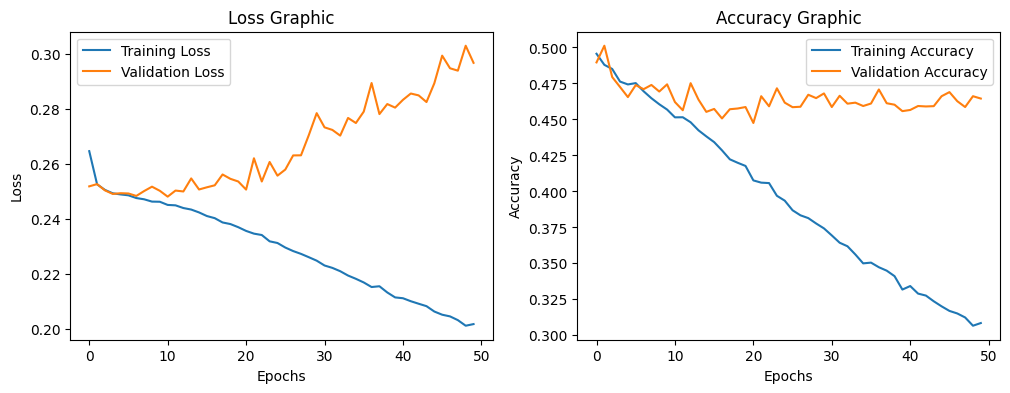

In [27]:
# Plotar o histórico do treinamento
plot_training_history(history_classifier)


--- Avaliando o modelo final (Siamese) ---
512/512 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

AUC da Curva Precision-Recall (Teste): 0.0632


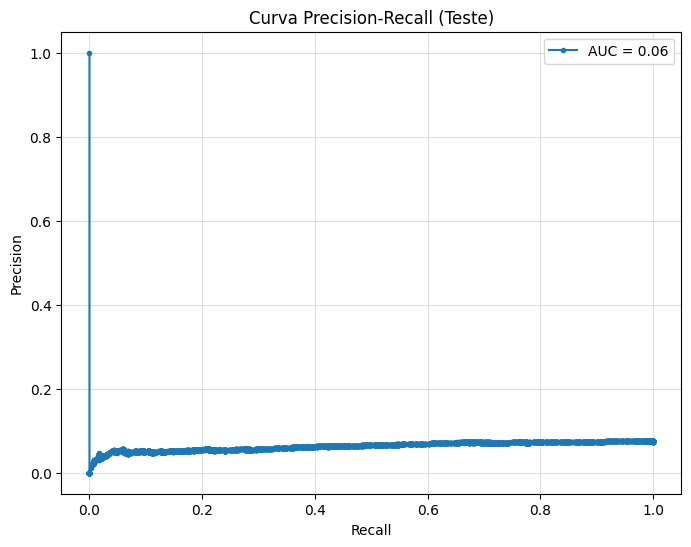

In [28]:
print("\n--- Avaliando o modelo final (Siamese) ---")

# Predições (distâncias)
dist_train = classifier_model.predict([train_left_balanced, train_right_balanced], batch_size=64).reshape(-1)
dist_valid = classifier_model.predict([valid_left_balanced, valid_right_balanced], batch_size=64).reshape(-1)
dist_test  = classifier_model.predict([test_left, test_right], batch_size=64).reshape(-1)

# Converter distância em score de similaridade (maior = mais classe 1)
score_train = np.exp(-dist_train)
score_valid = np.exp(-dist_valid)
score_test  = np.exp(-dist_test)

# Binarizar com o threshold escolhido
y_pred_train = (score_train >= 0.5).astype(int)
y_pred_valid = (score_valid >= 0.5).astype(int)
y_pred_test  = (score_test  >= 0.5).astype(int)

# PR-AUC no TESTE (usar *scores*, não rótulos hard)
precision, recall, _ = precision_recall_curve(y_test, score_test)
auc_pr = auc(recall, precision)
print(f"\nAUC da Curva Precision-Recall (Teste): {auc_pr:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'AUC = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall (Teste)')
plt.legend(loc='best')
plt.grid(alpha=0.4)
plt.show()

In [29]:
# Gerar o relatório de classificação
print("Validação:")
print(classification_report(y_valid_balanced, y_pred_valid, target_names=['Classe 0', 'Classe 1']))
print("\n#########################################################\n")
print("Teste:")
print(classification_report(y_test, y_pred_test, target_names=['Classe 0', 'Classe 1']))

Validação:
              precision    recall  f1-score   support

    Classe 0       0.68      0.10      0.18      4918
    Classe 1       0.51      0.95      0.67      4918

    accuracy                           0.53      9836
   macro avg       0.60      0.53      0.42      9836
weighted avg       0.60      0.53      0.42      9836


#########################################################

Teste:
              precision    recall  f1-score   support

    Classe 0       0.92      0.17      0.29      4354
    Classe 1       0.07      0.81      0.13       349

    accuracy                           0.22      4703
   macro avg       0.50      0.49      0.21      4703
weighted avg       0.86      0.22      0.28      4703



Validação:


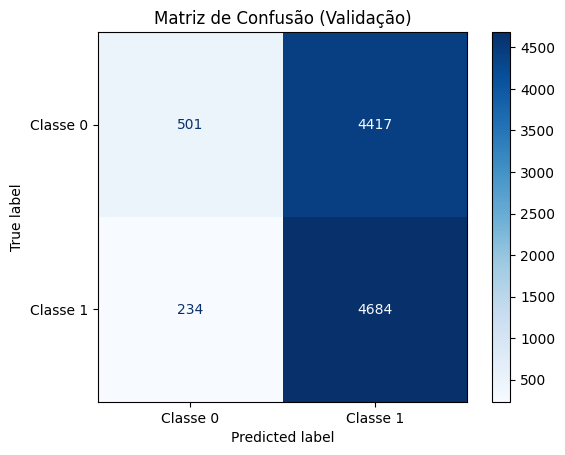

Teste:


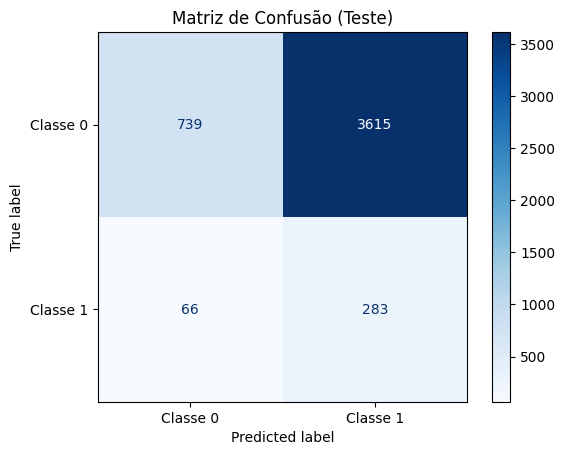

In [30]:
# Gerar a matriz de confusão
print("Validação:")
plot_confusion_matrix(y_valid_balanced, y_pred_valid, "Matriz de Confusão (Validação)")
print("Teste:")
plot_confusion_matrix(y_test, y_pred_test, "Matriz de Confusão (Teste)")

In [31]:
# Finaliza o wandb
wandb.finish()

epoch/accuracy,██▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
epoch/precision,███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁
epoch/recall,██▇▇▇▆▇▆▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
epoch/val_accuracy,▆█▅▄▃▄▄▄▅▃▅▃▂▂▁▂▂▁▃▄▂▂▄▃▄▃▃▃▃▃▃▃▂▂▃▃▃▃▂▃
epoch/val_loss,▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▃▂▃▂▃▃▄▅▄▄▅▅▅▅▆▅▆▆▇█▇▇█
epoch/val_precision,██▇▅▆▆▅▃▄▂▁▂▃▁▂▄▂▄▄▅▃▃▄▂▃▃▂▂▂▃▃▂▃▂▂▃▄▃▂▃
epoch/val_recall,▇█▄▃▄▄▂▁▂▂▁▁▂▁▁▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▂▂▁▂▁▂▁▂▂▁
epoch/accuracy,0.30855


#### Plotando PDFs para comparação dos resultados e análise das classificações

In [ ]:
# Função para adicionar borda ao patch com a cor da classificação
def add_border(image, color, thickness=3):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    bordered_image = cv2.copyMakeBorder(image_rgb, thickness, thickness, thickness, thickness, cv2.BORDER_CONSTANT, value=color)
    return bordered_image

# Função para carregar imagens no formato NIfTI (.nii.gz)
def load_nii_slice(patient_id, slice_index, base_path):
    coord_files = os.listdir(os.path.join(base_path, patient_id))
    if len(coord_files) > slice_index:
        nii_img = nib.load(os.path.join(base_path, patient_id, coord_files[slice_index]))
        img_data = nii_img.get_fdata()
        return img_data
    return None

# Função para carregar coordenadas de arquivos .txt
def load_coordinates(patient_id, slice_index, base_path):
    coord_files = os.listdir(os.path.join(base_path, patient_id))
    if len(coord_files) > slice_index:
        with open(os.path.join(base_path, patient_id, coord_files[slice_index]), "r") as file:
            coordinates = [tuple(map(int, line.strip().split(","))) for line in file]
        return coordinates
    return []

# Função para reconstruir a imagem e sobrepor o grid
def build_image_with_grid(patient_id, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, colors, index):
    img = load_nii_slice(patient_id, slice_index, image_path)
    img = cv2.normalize(img, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    mask = load_nii_slice(patient_id, slice_index, mask_path)
    mask = cv2.normalize(mask, None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    coordinates = load_coordinates(patient_id, slice_index, coordinates_path)
    
    if img is None or mask is None or not coordinates:
        return None, None, index

    reconstructed_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    reconstructed_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        
    half = len(coordinates)
    classifications = []

    for i in range(half):
        true = labels_true[i + index]
        pred = labels_pred[i + index]
        if pred == true:
            if pred == 1:
                classif = "TP" 
            else:
                classif = "TN"
        else:
            if pred == 1:
                classif = "FP"
            else: 
                classif = "FN"
        classifications.append(classif)
    
    # Repetir a classificação para o lado direito
    classifications.extend(classifications)

    for i, (y1, y2, x1, x2) in enumerate(coordinates):
        classif = classifications[i]

        patch_img = img[y1+3:y2-3, x1+3:x2-3]
        patch_mask = mask[y1+3:y2-3, x1+3:x2-3]

        bordered_patch_img = add_border(patch_img, colors[classif])
        bordered_patch_mask = add_border(patch_mask, colors[classif])

        reconstructed_img[y1:y2, x1:x2] = bordered_patch_img
        reconstructed_mask[y1:y2, x1:x2] = bordered_patch_mask

    return reconstructed_img, reconstructed_mask, index+half

In [ ]:
def plot_patient_slices(pdf_filename, patients, coordinates_path, image_path, mask_path, labels_true, labels_pred):
    os.makedirs(os.path.dirname(pdf_filename), exist_ok=True)
    
    colors = {"TP": (0, 255, 0), "TN": (127, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
    with PdfPages(pdf_filename) as pdf:
        index = 0
        for patient in patients:

            fig_legend, ax_legend = plt.subplots(figsize=(6, 4))
            ax_legend.axis("off")
            
            legend_patches = [
                mpatches.Patch(color=np.array(rgb)/255., label=name) 
                for name, rgb in colors.items()
            ]
            
            # Add the legend to the center of the figure
            ax_legend.legend(handles=legend_patches, loc='center', fontsize=14, title="Legenda de Cores")
            fig_legend.suptitle(f"Legenda para Paciente {patient}", fontsize=16)
            
            pdf.savefig(fig_legend)
            plt.close(fig_legend)
            for slice_index in range(test_slices_quantity[patient]):
                img_recon, mask_recon, index = build_image_with_grid(patient, slice_index, labels_pred, labels_true, image_path, mask_path, coordinates_path, colors, index)
                
                fig, axs = plt.subplots(2, 1, figsize=(6, 6))
                axs[0].imshow(img_recon, cmap='gray')
                axs[0].set_title(f'Paciente {patient} - Imagem')
                axs[0].axis('off')
                axs[1].imshow(mask_recon, cmap='gray')
                axs[1].set_title(f'Paciente {patient} - Máscara')
                axs[1].axis('off')
                
                pdf.savefig(fig)
                plt.close(fig)
                
        print(f"As imagens foram salvas no arquivo PDF {pdf_filename} com sucesso.")

# Chamando a função para gerar o PDF
test_slices_quantity = {'sub-42B05': 137, 'sub-42K06': 130, 'sub-44H05': 140, 'sub-86G08': 135}
plot_patient_slices(
    pdf_filename="Pdf_SSCL/Pacientes_Test_Reconstruidos.pdf",
    patients=test_patients,
    coordinates_path="Coordenadas_grid",
    image_path="Fatias_Patients",
    mask_path="Fatias_Mask",
    labels_true=np.concatenate((y_test_left, y_test_right), axis=0),
    labels_pred=y_pred_test,
)

As imagens foram salvas no arquivo PDF Pdf_SSCL/Pacientes_Test_Reconstruidos.pdf com sucesso.


In [ ]:
def plot_patches_patient_slices_with_borders_and_masks(
    pdf_folder, patients, image_left, image_right,
    mask_left, mask_right, labels_true, labels_pred
):
    os.makedirs(pdf_folder, exist_ok=True)

    colors = {"TP": (0, 255, 0), "TN": (127, 255, 0), "FP": (255, 0, 0), "FN": (255, 255, 0)}
    index = 0
    for patient in patients:
        num_patches = len(image_left[patient])
        patient_folder = os.path.join(pdf_folder, patient)
        os.makedirs(patient_folder, exist_ok=True)
        pdf_filename = os.path.join(patient_folder, f"Paciente_{patient}.pdf")

        with PdfPages(pdf_filename) as pdf:
            fig_legend, ax_legend = plt.subplots(figsize=(6, 4))
            ax_legend.axis("off")
            
            legend_patches = [
                mpatches.Patch(color=np.array(rgb)/255., label=name) 
                for name, rgb in colors.items()
            ]
            
            # Add the legend to the center of the figure
            ax_legend.legend(handles=legend_patches, loc='center', fontsize=14, title="Legenda de Cores")
            fig_legend.suptitle(f"Legenda para Paciente {patient}", fontsize=16)
            
            pdf.savefig(fig_legend)
            plt.close(fig_legend)
            for i in range(num_patches):
                true = labels_true[index+i]
                pred = labels_pred[index+i]
                if pred == true:
                    if pred == 1 and true == 1:
                        classif = "TP" 
                    else:
                        classif = "TN"
                else:
                    if pred == 1 and true == 0:
                        classif = "FP" 
                    else: 
                        classif = "FN"
                color = colors[classif]

                patch_l = cv2.normalize(image_left[patient][i], None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
                patch_r = cv2.normalize(image_right[patient][i], None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
                mask_l = cv2.normalize(mask_left[patient][i], None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
                mask_r = cv2.normalize(mask_right[patient][i], None, alpha=255, beta=0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

                patch_l_border = add_border(patch_l, color)
                patch_r_border = add_border(patch_r, color)
                mask_l_border = add_border(mask_l, color)
                mask_r_border = add_border(mask_r, color)

                fig, axs = plt.subplots(2, 2, figsize=(6, 6))
                axs[0, 0].imshow(patch_l_border)
                axs[0, 0].set_title("Esquerda")
                axs[0, 1].imshow(patch_r_border)
                axs[0, 1].set_title("Direita")
                axs[1, 0].imshow(mask_l_border)
                axs[1, 0].set_title("Másc. Esq.")
                axs[1, 1].imshow(mask_r_border)
                axs[1, 1].set_title("Másc. Dir.")

                for ax in axs.flat:
                    ax.axis("off")

                fig.suptitle(f"{patient} | {classif} | idx {index}", fontsize=10)
                pdf.savefig(fig)
                plt.close(fig)

                index += 1

        print(f"✅ PDF salvo: {pdf_filename}")
    print(f"\n📂 Todos os PDFs foram salvos em: {pdf_folder}")

plot_patches_patient_slices_with_borders_and_masks(
    pdf_folder="Pdf_SSCL/Patches_treino",
    patients=train_patients,
    image_left=train_left_balanced,
    image_right=train_right_balanced,
    mask_left=balanced_mask_left,
    mask_right=balanced_mask_right,
    labels_true=np.concatenate((y_train_left_balanced, y_train_right_balanced), axis=0),
    labels_pred=y_pred_train
)

# plot_patches_patient_slices_with_borders_and_masks(
#     pdf_folder="Pdf_SSCL/Patches_validacao",
#     patients=valid_patients,
#     image_left=valid_left_balanced,
#     image_right=valid_right_balanced,
#     mask_left=balanced_mask_left,
#     mask_right=balanced_mask_right,
#     labels_true=np.concatenate((y_valid_left_balanced, y_valid_right_balanced), axis=0),
#     labels_pred=y_pred_valid
# )

✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-02A13\Paciente_sub-02A13.pdf
✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-03C08\Paciente_sub-03C08.pdf
✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-06C09\Paciente_sub-06C09.pdf
✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-14F04\Paciente_sub-14F04.pdf
✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-16E03\Paciente_sub-16E03.pdf
✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-16G09\Paciente_sub-16G09.pdf
✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-16I12\Paciente_sub-16I12.pdf
✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-19F09\Paciente_sub-19F09.pdf
✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-19G04\Paciente_sub-19G04.pdf
✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-22F14\Paciente_sub-22F14.pdf
✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-26B09\Paciente_sub-26B09.pdf
✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-31F07\Paciente_sub-31F07.pdf
✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-35E12\Paciente_sub-35E12.pdf
✅ PDF salvo: Pdf_SSCL/Patches_treino\sub-36K02\Paciente_sub-36K02.pdf
✅ PDF salvo: Pdf_SSC

: 